In [1]:
import torch

# 현재 Setup 되어있는 device 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Available devices ', torch.cuda.device_count())

print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))

Available devices  4
Current cuda device  0
TITAN RTX


In [2]:
GPU_NUM = 2 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

 
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  2
TITAN RTX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import  transforms, datasets

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers) # *으로 list unpacking 

            return cbr
        
        
        #Define layers
        
        #Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        self.enc5_2 = CBR2d(in_channels=1024, out_channels=1024)
        
        #CenterCropping 
#         self.crop4 = transforms.CenterCrop(56)
#         self.crop3 = transforms.CenterCrop(104)
#         self.crop2 = transforms.CenterCrop(200)
#         self.crop1 = transforms.CenterCrop(388)  # input size 512*512 기준
        
        #Expanding path
        self.unpool4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec4_2 = CBR2d(in_channels=1024, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=512)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CBR2d(in_channels=512, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=256)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CBR2d(in_channels=256, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=128)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CBR2d(in_channels=128, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64,
                                 kernel_size=1, stride=1, padding=0, bias=True)
        
        self.conv1a = nn.Conv2d(in_channels=64, out_channels=16,
                                 kernel_size=1, stride=1, padding=0, bias=True)
        
        self.conv1b = nn.Conv2d(in_channels=16, out_channels=1,
                                 kernel_size=1, stride=1, padding=0, bias=True)
        
        self.out_1 = nn.BatchNorm2d(num_features=1)
        self.out = nn.Sigmoid()
        
    #forwarding
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)
            
        unpool4 = self.unpool4(enc5_2)
        # concatenate croped_enc4_2
        crop4 = enc4_2#[:, :, 4:60, 4:60]
        refine4 = torch.cat((crop4, unpool4), dim=1) #dim 0,1,2,3 = batch,channel,width,height
        dec4_2 = self.dec4_2(refine4) 
        dec4_1 = self.dec4_1(dec4_2)
        unpool3 = self.unpool3(dec4_1)
        #concatenate croped_enc3_2
        crop3 = enc3_2#[:, :, 16:120, 16:120]
        refine3 = torch.cat((crop3, unpool3), dim=1)
        dec3_2 = self.dec3_2(refine3)
        dec3_1 = self.dec3_1(dec3_2)
        unpool2 = self.unpool2(dec3_1)
        #concatenate croped_enc2_2
        crop2 = enc2_2#[:, :, 40:240, 40:240]
        refine2 = torch.cat((crop2, unpool2), dim=1)
        dec2_2 = self.dec2_2(refine2)
        dec2_1 = self.dec2_1(dec2_2)
        unpool1 = self.unpool1(dec2_1)
        #concatenate croped_enc1_2
        crop1 = enc1_2#[:, :, 88:480, 88:480]
        refine1 = torch.cat((crop1, unpool1), dim=1)
        dec1_2 = self.dec1_2(refine1)
        dec1_1 = self.dec1_1(dec1_2)
        
        conv1 = self.conv1(dec1_1)
        conv1a = self.conv1a(conv1)
        conv1b = self.conv1b(conv1a)
        out_1 = self.out_1(conv1b)
        out = self.out(out_1)

        return out
        

In [6]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         # 1 input image channel, 6 output channels, 3x3 square convolution
#         # kernel
#         self.conv1 = nn.Conv2d(1, 6, 3)
#         self.conv2 = nn.Conv2d(6, 16, 3)
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         # Max pooling over a (2, 2) window
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square you can only specify a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features


# net = Net()
# print(net)

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        lst_data = os.listdir(self.data_dir)
        
        # 문자열 검사해서 'label'이 있으면 True 
        # 문자열 검사해서 'train'이 있으면 True
        lst_label = [f for f in lst_data if f.startswith('label_')] 
        lst_input = [f for f in lst_data if f.startswith('train')] 
        
        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input
    
    def __len__(self):
        return len(self.lst_label)
    
    # 데이터 load 파트
    def __getitem__(self, index):

        label_img = Image.open(os.path.join(self.data_dir, self.lst_label[index]))
        label = np.array(label_img.getdata())
        label = np.reshape(label, (512,512))
        
        input_img = Image.open(os.path.join(self.data_dir, self.lst_input[index]))
        inputs = np.array(input_img.getdata())
        inputs = np.reshape(inputs, (512,512))
    
        #label = np.load(os.path.join(self.data_dir, self.lst_label[index]), allow_pickle=True)
        #inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]), allow_pickle=True)
        
        
        # normalize, 이미지는 0~255 값을 가지고 있어 이를 0~1사이로 scaling
        #label = label/255.0, label은 어차피 1, input은 최대값을 기준으로 normalize
        label = label/np.max(label)
        inputs = inputs/np.max(inputs)
        label = label.astype(np.float32)
        inputs = inputs.astype(np.float32) 

        
        # 인풋 데이터 차원이 2이면, 채널 축을 추가해줘야한다. 
        # 파이토치 인풋 format (batch, 채널, 행, 열)
        
        if label.ndim == 2:
            label = label[:,:,np.newaxis]    #파이토치 인풋 포맷을 보고도 맨 뒤에 새로운 축을 생성하는 이유는 다음 class에서 확인하기
        if inputs.ndim == 2:  
            inputs = inputs[:,:,np.newaxis] 
        
        data = {'input':inputs, 'label':label}

        # transform에 할당된 class 들이 호출되면서 __call__ 함수 실행
        if self.transform:
            data = self.transform(data)
    
        return data

In [8]:
class ToTensor(object):
    def __call__(self, data):
        label, inputs = data['label'], data['input']
   
        # numpy와 tensor의 배열 차원 순서가 다르다. 
        # numpy : (행, 열, 채널)
        # tensor : (채널, 행, 열)
        # 따라서 위 순서에 맞춰 transpose
        
        label = label.transpose((2, 0, 1)).astype(np.float32) 
        inputs = inputs.transpose((2, 0, 1)).astype(np.float32)
        
        # 이후 np를 tensor로 바꾸는 코드는 다음과 같이 간단하다.
        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(inputs)}

        return data

In [13]:
## 하이퍼 파라미터 설정
lr = 1e-3
batch_size = 4
num_epoch = 300

data_dir = './data'
ckpt_dir = './ckpt0319_2'
log_dir = './log'
res_dir = './result'

patience = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# transform 적용해서 데이터 셋 불러오기
#transform = transforms.Compose(transforms.Normalize(0.5, 0.5), ToTensor())
dataset_train = Dataset(data_dir=os.path.join(data_dir,'train'),transform=ToTensor())

# 불러온 데이터셋, 배치 size줘서 DataLoader 해주기
loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)

# val set도 동일하게 진행
dataset_val = Dataset(data_dir=os.path.join(data_dir,'val'),transform = ToTensor())
loader_val = DataLoader(dataset_val, batch_size=1 , shuffle=True)

# 네트워크 불러오기
net = UNet().to(device) # device : cpu or gpu

# loss 정의
fn_loss = nn.MSELoss().to(device)

# Optimizer 정의
optim = torch.optim.Adam(net.parameters(), lr = lr ) 

# 기타 variables 설정
num_train = len(dataset_train)
num_val = len(dataset_val)

num_train_for_epoch = np.ceil(num_train/batch_size) # np.ceil : 소수점 반올림
num_val_for_epoch = np.ceil(num_val/batch_size)

# 기타 function 설정
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

# Tensorbord
writer_train = SummaryWriter(log_dir = os.path.join(log_dir,'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir,'val'))

In [15]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({'net':net.state_dict()},'%s'%(self.path))
        self.val_loss_min = val_loss

In [16]:
# 네트워크 저장하기
# train을 마친 네트워크 저장 
# net : 네트워크 파라미터, optim  두개를 dict 형태로 저장
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch), _use_new_zipfile_serialization=False)

# 네트워크 불러오기
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch 
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str,isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch

early_stopping = EarlyStopping(patience = patience, verbose = True)

# 네트워크 학습시키기
start_epoch = 0
net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim) # 저장된 네트워크 불러오기

for epoch in range(start_epoch+1,num_epoch +1):
    net.train()
    loss_arr = []

    for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        label = data['label'].to(device)   # 데이터 device로 올리기  
        inputs = data['input'].to(device)
        output = net(inputs) 
        #plt.imshow(index[0,0,:,:], cmap='gray')

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update

        # save loss
        print(loss.item())
        loss_arr += [loss.item()]

        # tensorbord에 결과값들 저정하기
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
        output = fn_tonumpy(fn_classifier(output))

        writer_train.add_image('label', label, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', inputs, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    
    # validation
    with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
        net.eval() # 네트워크를 evaluation 용으로 선언
        loss_arr = []

        for batch, data in enumerate(loader_val,1):
            # forward
            label = data['label'].to(device)
            inputs = data['input'].to(device)
            output = net(inputs)

            # loss 
            loss = fn_loss(fn_classifier(output),label)
            loss_arr += [loss.item()]     
            print('valid : epoch %04d / %04d | Batch %04d \ %f | Loss %f'%(epoch,num_epoch,batch,num_val_for_epoch,np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_classifier(output))

            writer_val.add_image('label', label, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', inputs, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
        
        early_stopping(np.mean(loss_arr), net)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        # epoch이 끝날때 마다 네트워크 저장
        save(ckpt_dir=ckpt_dir, net = net, optim = optim, epoch = epoch)

writer_train.close()
writer_val.close()

0.24558818340301514
0.23343999683856964
0.2343558669090271
0.23290297389030457
valid : epoch 0001 / 0300 | Batch 0001 \ 1.000000 | Loss 0.013596
valid : epoch 0001 / 0300 | Batch 0002 \ 1.000000 | Loss 0.048815
Validation loss decreased (inf --> 0.048815).  Saving model ...
0.2303486168384552
0.2326323539018631
0.2302856743335724
0.2308516502380371
valid : epoch 0002 / 0300 | Batch 0001 \ 1.000000 | Loss 0.008194
valid : epoch 0002 / 0300 | Batch 0002 \ 1.000000 | Loss 0.034805
Validation loss decreased (0.048815 --> 0.034805).  Saving model ...
0.23103156685829163
0.2290862500667572
0.22876009345054626
0.2301000952720642
valid : epoch 0003 / 0300 | Batch 0001 \ 1.000000 | Loss 0.006588
valid : epoch 0003 / 0300 | Batch 0002 \ 1.000000 | Loss 0.029579
Validation loss decreased (0.034805 --> 0.029579).  Saving model ...
0.22982372343540192
0.2270040512084961
0.2271931916475296
0.22801154851913452
valid : epoch 0004 / 0300 | Batch 0001 \ 1.000000 | Loss 0.005730
valid : epoch 0004 / 0300

0.19931533932685852
0.197793111205101
0.19799110293388367
valid : epoch 0033 / 0300 | Batch 0001 \ 1.000000 | Loss 0.013626
valid : epoch 0033 / 0300 | Batch 0002 \ 1.000000 | Loss 0.031534
EarlyStopping counter: 13 out of 300
0.19541296362876892
0.19721730053424835
0.19624747335910797
0.19860035181045532
valid : epoch 0034 / 0300 | Batch 0001 \ 1.000000 | Loss 0.052010
valid : epoch 0034 / 0300 | Batch 0002 \ 1.000000 | Loss 0.032488
EarlyStopping counter: 14 out of 300
0.19641408324241638
0.19649802148342133
0.19401699304580688
0.19871258735656738
valid : epoch 0035 / 0300 | Batch 0001 \ 1.000000 | Loss 0.039280
valid : epoch 0035 / 0300 | Batch 0002 \ 1.000000 | Loss 0.025034
EarlyStopping counter: 15 out of 300
0.1924462616443634
0.1969156265258789
0.1942046582698822
0.19419822096824646
valid : epoch 0036 / 0300 | Batch 0001 \ 1.000000 | Loss 0.065716
valid : epoch 0036 / 0300 | Batch 0002 \ 1.000000 | Loss 0.039656
EarlyStopping counter: 16 out of 300
0.19383013248443604
0.1933403

0.16899517178535461
0.16865772008895874
valid : epoch 0066 / 0300 | Batch 0001 \ 1.000000 | Loss 0.020149
valid : epoch 0066 / 0300 | Batch 0002 \ 1.000000 | Loss 0.014780
EarlyStopping counter: 46 out of 300
0.16798098385334015
0.16805563867092133
0.16832411289215088
0.16624483466148376
valid : epoch 0067 / 0300 | Batch 0001 \ 1.000000 | Loss 0.037769
valid : epoch 0067 / 0300 | Batch 0002 \ 1.000000 | Loss 0.025145
EarlyStopping counter: 47 out of 300
0.16850563883781433
0.16719499230384827
0.1662067174911499
0.1682024896144867
valid : epoch 0068 / 0300 | Batch 0001 \ 1.000000 | Loss 0.011414
valid : epoch 0068 / 0300 | Batch 0002 \ 1.000000 | Loss 0.022743
EarlyStopping counter: 48 out of 300
0.16665738821029663
0.1660427302122116
0.16587550938129425
0.16647520661354065
valid : epoch 0069 / 0300 | Batch 0001 \ 1.000000 | Loss 0.027550
valid : epoch 0069 / 0300 | Batch 0002 \ 1.000000 | Loss 0.019146
EarlyStopping counter: 49 out of 300
0.16545936465263367
0.1676263064146042
0.164363

0.14340297877788544
valid : epoch 0099 / 0300 | Batch 0001 \ 1.000000 | Loss 0.024971
valid : epoch 0099 / 0300 | Batch 0002 \ 1.000000 | Loss 0.017345
EarlyStopping counter: 79 out of 300
0.14397013187408447
0.14281420409679413
0.14428839087486267
0.1467115879058838
valid : epoch 0100 / 0300 | Batch 0001 \ 1.000000 | Loss 0.027538
valid : epoch 0100 / 0300 | Batch 0002 \ 1.000000 | Loss 0.018517
EarlyStopping counter: 80 out of 300
0.14341649413108826
0.1437385082244873
0.14328929781913757
0.14218772947788239
valid : epoch 0101 / 0300 | Batch 0001 \ 1.000000 | Loss 0.008461
valid : epoch 0101 / 0300 | Batch 0002 \ 1.000000 | Loss 0.013844
EarlyStopping counter: 81 out of 300
0.14360660314559937
0.14292505383491516
0.141413152217865
0.14380675554275513
valid : epoch 0102 / 0300 | Batch 0001 \ 1.000000 | Loss 0.021255
valid : epoch 0102 / 0300 | Batch 0002 \ 1.000000 | Loss 0.015287
EarlyStopping counter: 82 out of 300
0.14265814423561096
0.14384011924266815
0.14082574844360352
0.140650

valid : epoch 0132 / 0300 | Batch 0001 \ 1.000000 | Loss 0.015999
valid : epoch 0132 / 0300 | Batch 0002 \ 1.000000 | Loss 0.011810
EarlyStopping counter: 112 out of 300
0.12612122297286987
0.12358176708221436
0.12271454930305481
0.12493893504142761
valid : epoch 0133 / 0300 | Batch 0001 \ 1.000000 | Loss 0.008266
valid : epoch 0133 / 0300 | Batch 0002 \ 1.000000 | Loss 0.015022
EarlyStopping counter: 113 out of 300
0.12501496076583862
0.12292143702507019
0.12352628260850906
0.12156453728675842
valid : epoch 0134 / 0300 | Batch 0001 \ 1.000000 | Loss 0.007889
valid : epoch 0134 / 0300 | Batch 0002 \ 1.000000 | Loss 0.013834
EarlyStopping counter: 114 out of 300
0.12318556010723114
0.12159086763858795
0.12397544085979462
0.12512123584747314
valid : epoch 0135 / 0300 | Batch 0001 \ 1.000000 | Loss 0.007519
valid : epoch 0135 / 0300 | Batch 0002 \ 1.000000 | Loss 0.013765
EarlyStopping counter: 115 out of 300
0.12301678955554962
0.12311802804470062
0.12155289947986603
0.1253092736005783
v

0.10927455872297287
valid : epoch 0165 / 0300 | Batch 0001 \ 1.000000 | Loss 0.006542
valid : epoch 0165 / 0300 | Batch 0002 \ 1.000000 | Loss 0.010395
EarlyStopping counter: 145 out of 300
0.11038786172866821
0.10767079889774323
0.10776051133871078
0.10647838562726974
valid : epoch 0166 / 0300 | Batch 0001 \ 1.000000 | Loss 0.015057
valid : epoch 0166 / 0300 | Batch 0002 \ 1.000000 | Loss 0.011072
EarlyStopping counter: 146 out of 300
0.10752154886722565
0.10983546078205109
0.10559439659118652
0.10761281102895737
valid : epoch 0167 / 0300 | Batch 0001 \ 1.000000 | Loss 0.006226
valid : epoch 0167 / 0300 | Batch 0002 \ 1.000000 | Loss 0.008854
EarlyStopping counter: 147 out of 300
0.10618914663791656
0.10965211689472198
0.10537788271903992
0.10789927840232849
valid : epoch 0168 / 0300 | Batch 0001 \ 1.000000 | Loss 0.028362
valid : epoch 0168 / 0300 | Batch 0002 \ 1.000000 | Loss 0.018389
EarlyStopping counter: 148 out of 300
0.10924453288316727
0.10646672546863556
0.1061435341835022
0

0.09551303088665009
0.09503651410341263
0.09381098300218582
valid : epoch 0198 / 0300 | Batch 0001 \ 1.000000 | Loss 0.012920
valid : epoch 0198 / 0300 | Batch 0002 \ 1.000000 | Loss 0.009531
EarlyStopping counter: 8 out of 300
0.09404738992452621
0.09542248398065567
0.0942465141415596
0.09325829893350601
valid : epoch 0199 / 0300 | Batch 0001 \ 1.000000 | Loss 0.014393
valid : epoch 0199 / 0300 | Batch 0002 \ 1.000000 | Loss 0.010218
EarlyStopping counter: 9 out of 300
0.0938226729631424
0.0929197445511818
0.0945710763335228
0.09520925581455231
valid : epoch 0200 / 0300 | Batch 0001 \ 1.000000 | Loss 0.006939
valid : epoch 0200 / 0300 | Batch 0002 \ 1.000000 | Loss 0.013300
EarlyStopping counter: 10 out of 300
0.09343168139457703
0.09252628684043884
0.09445296227931976
0.09542959928512573
valid : epoch 0201 / 0300 | Batch 0001 \ 1.000000 | Loss 0.005344
valid : epoch 0201 / 0300 | Batch 0002 \ 1.000000 | Loss 0.007366
Validation loss decreased (0.008018 --> 0.007366).  Saving model ..

0.08206282556056976
0.08398064970970154
0.0833880603313446
0.08130785822868347
valid : epoch 0231 / 0300 | Batch 0001 \ 1.000000 | Loss 0.006065
valid : epoch 0231 / 0300 | Batch 0002 \ 1.000000 | Loss 0.009878
EarlyStopping counter: 1 out of 300
0.08255775272846222
0.08448351919651031
0.08157402276992798
0.08263495564460754
valid : epoch 0232 / 0300 | Batch 0001 \ 1.000000 | Loss 0.011444
valid : epoch 0232 / 0300 | Batch 0002 \ 1.000000 | Loss 0.008503
EarlyStopping counter: 2 out of 300
0.08226250112056732
0.08216085284948349
0.08247005939483643
0.08139201998710632
valid : epoch 0233 / 0300 | Batch 0001 \ 1.000000 | Loss 0.011517
valid : epoch 0233 / 0300 | Batch 0002 \ 1.000000 | Loss 0.008644
EarlyStopping counter: 3 out of 300
0.08195935934782028
0.08356831967830658
0.08138834685087204
0.08067824691534042
valid : epoch 0234 / 0300 | Batch 0001 \ 1.000000 | Loss 0.005493
valid : epoch 0234 / 0300 | Batch 0002 \ 1.000000 | Loss 0.007427
EarlyStopping counter: 4 out of 300
0.0826994

0.07268823683261871
0.0727042406797409
0.07288788259029388
0.07439866662025452
valid : epoch 0264 / 0300 | Batch 0001 \ 1.000000 | Loss 0.013172
valid : epoch 0264 / 0300 | Batch 0002 \ 1.000000 | Loss 0.009712
EarlyStopping counter: 23 out of 300
0.07300134748220444
0.07266086339950562
0.07192504405975342
0.07329460233449936
valid : epoch 0265 / 0300 | Batch 0001 \ 1.000000 | Loss 0.010223
valid : epoch 0265 / 0300 | Batch 0002 \ 1.000000 | Loss 0.008156
EarlyStopping counter: 24 out of 300
0.07320478558540344
0.07352166622877121
0.07160807400941849
0.07156164199113846
valid : epoch 0266 / 0300 | Batch 0001 \ 1.000000 | Loss 0.013275
valid : epoch 0266 / 0300 | Batch 0002 \ 1.000000 | Loss 0.010054
EarlyStopping counter: 25 out of 300
0.07179021835327148
0.07210245728492737
0.07200980931520462
0.07208797335624695
valid : epoch 0267 / 0300 | Batch 0001 \ 1.000000 | Loss 0.006554
valid : epoch 0267 / 0300 | Batch 0002 \ 1.000000 | Loss 0.010145
EarlyStopping counter: 26 out of 300
0.070

0.06378939747810364
0.06472614407539368
0.06515638530254364
0.06511187553405762
valid : epoch 0297 / 0300 | Batch 0001 \ 1.000000 | Loss 0.007263
valid : epoch 0297 / 0300 | Batch 0002 \ 1.000000 | Loss 0.005823
EarlyStopping counter: 5 out of 300
0.06465329229831696
0.06527317315340042
0.0635039433836937
0.06455127894878387
valid : epoch 0298 / 0300 | Batch 0001 \ 1.000000 | Loss 0.010113
valid : epoch 0298 / 0300 | Batch 0002 \ 1.000000 | Loss 0.007730
EarlyStopping counter: 6 out of 300
0.06420288980007172
0.06413650512695312
0.06350578367710114
0.0652451142668724
valid : epoch 0299 / 0300 | Batch 0001 \ 1.000000 | Loss 0.012375
valid : epoch 0299 / 0300 | Batch 0002 \ 1.000000 | Loss 0.008820
EarlyStopping counter: 7 out of 300
0.0657278373837471
0.06343474984169006
0.0636083334684372
0.0641070082783699
valid : epoch 0300 / 0300 | Batch 0001 \ 1.000000 | Loss 0.005135
valid : epoch 0300 / 0300 | Batch 0002 \ 1.000000 | Loss 0.008568
EarlyStopping counter: 8 out of 300


#Failed to interpret file './data/train/label_16_03.tif' as a pickle
#무슨 뜻인지 1시간 정도 고민했는데, image file이 numpy형태로 변환이 안돼서 그런게 아닐까하는 생각을 했다.
#transform이 잘 안되고 있다. tif 파일을 넘파이 배열로 저장시켜야 하는데 그게 안되기 때문에 np.load가 안되고 있는 상황
#transform 은 이상 없었음. 파일을 넘파이로 바꿔주니 잘 넘어감
#넘어는 가는데 input size를 (1,512,512)로 설정해서 train을 하고자 하였지만 들어가는 size가 (4,1,512,512)가 된다. 이유 확인하자
#input format은 이게 맞다. NotImplementedError가 나온건 내가 forward 메소드를 __init__안에다 정의해서 그렇다. 
#그러나 이젠 다른 에러가 나타났다. 맙소사
#뭐였더라, crop 이 안됐었는데 nn.module 내에서 transforms.CenterCrop을 정의했던게 문제였다.
#train은 성공, 
#cuda0 이면 tensor -> numpy 로 전환할 때 >>> x.detach().cpu().numpy() 를 해야 바뀐다. 쿠다 아니면 x.numpy()바로 가능

loss is 0.033833 
 accuracy is 0.966167 


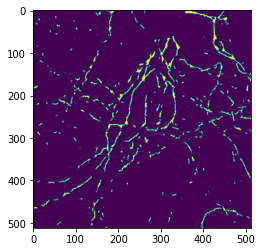

loss is 0.029411 
 accuracy is 0.970589 


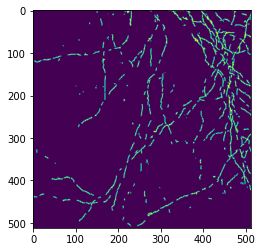

loss is 0.039841 
 accuracy is 0.960159 


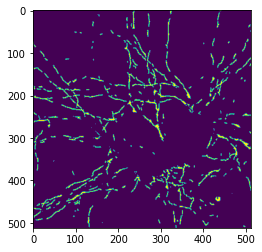

loss is 0.016090 
 accuracy is 0.983910 


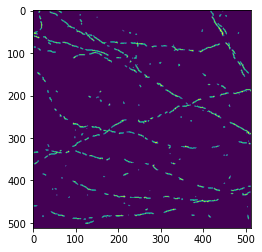

In [18]:
#Let's test
dict_model = torch.load('%s/%s' % (ckpt_dir,'model_epoch200.pth'))

net.load_state_dict(dict_model['net'])
cnt = 1
# test set도 동일하게 진행
dataset_test = Dataset(data_dir=os.path.join(data_dir,'test'),transform = ToTensor())
loader_test = DataLoader(dataset_test, batch_size=1 , shuffle=False)

for batch, data in enumerate(loader_test,1):
    # forward
    label = data['label'].to(device)
    inputs = data['input'].to(device)
    output = net(inputs)
    loss = fn_loss(fn_classifier(output),label)
    acc = (fn_classifier(output) == label).float().sum()
    print("loss is %f \n accuracy is %f " %(loss,acc/(512*512)))
    output = fn_tonumpy(fn_classifier(output))
    img = Image.fromarray(np.squeeze(output))
    img.save('%s/%s/result%d.tif' %(data_dir,res_dir,cnt))
    cnt += 1
    plt.imshow(np.squeeze(output))#, interpolation='nearest')
    plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count